In [206]:
import torch
import torchvision
import torchvision.transforms as transforms
import skimage.io as skio
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from torchmetrics import PeakSignalNoiseRatio

path = 'lion_orig.png'
img = skio.imread(path)
target = torch.tensor(img/255., dtype=torch.float).cuda()

In [193]:
configs = {
    'lr': .0001,
    'bs': 128,
    'epochs': 2000
}

In [214]:
class MLP(nn.Module):
    def __init__(self, num_layers=3, num_channels=256):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers += [nn.Linear(2, num_channels), nn.ReLU()]
        for _ in range(num_layers):
            self.layers += [nn.Linear(num_channels, num_channels)]
            self.layers += [nn.ReLU()]
        self.layers += [nn.Linear(num_channels, num_layers)]
        self.layers += [nn.Sigmoid()]
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def render(model, x_train):
    output = model(torch.tensor(x_train, dtype=torch.float).cuda()).detach().cpu().numpy()
    return output.reshape(img.shape)
    
def train(model, criterion, optimizer, configs, x_train):
    for epoch in range(configs['epochs']):
        running_loss = 0
        inputs = x_train
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.reshape(img.shape), target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if epoch % 200 == 0:
            with torch.no_grad():
                out, t = model(x_train).reshape(img.shape).detach().cpu().numpy(), target.detach().cpu().numpy()
                fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
                ax1.imshow(t)
                ax2.imshow(out)
                plt.show()
                print('PSNR:', psnr(torch.tensor(out), torch.tensor(t)))
    return

In [215]:
model = MLP().cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=configs['lr'])
psnr = PeakSignalNoiseRatio()
coords = np.linspace(0, img.shape[0], img.shape[0], endpoint=False)
x_train = np.stack(np.meshgrid(coords, coords), -1)
x_train = torch.tensor(x_train.reshape(x_train.shape[0] ** 2, 2), dtype=torch.float)/x_train.shape[0]
x_train = x_train.cuda()

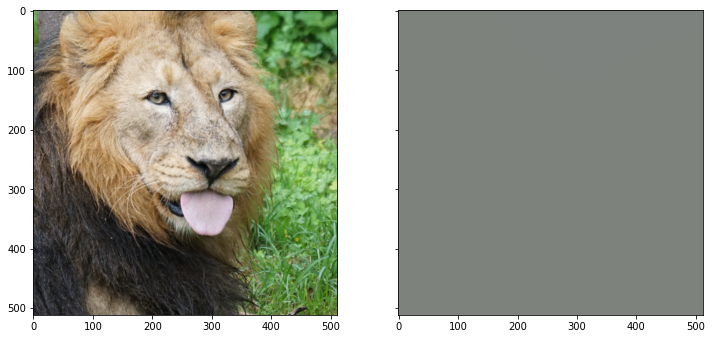

PSNR: tensor(12.2795)


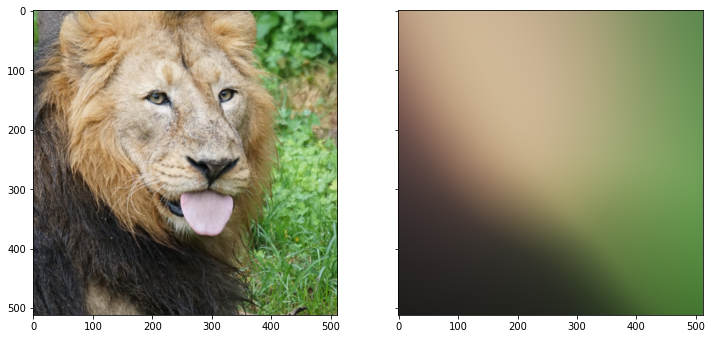

PSNR: tensor(16.6814)


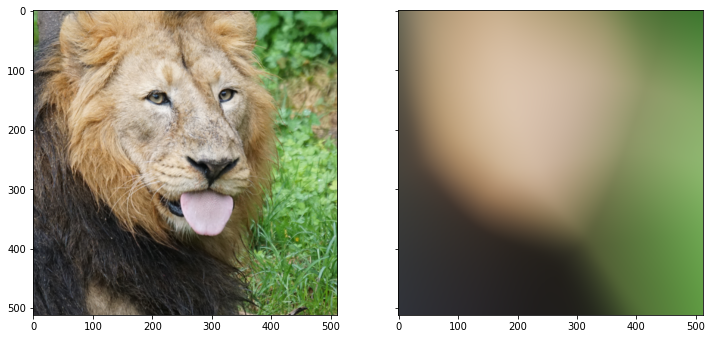

PSNR: tensor(17.5148)


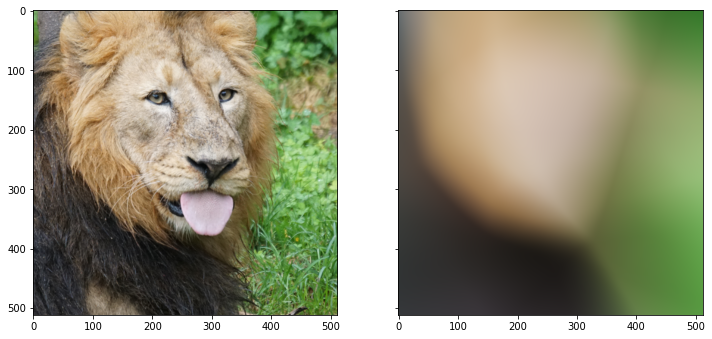

PSNR: tensor(17.9266)


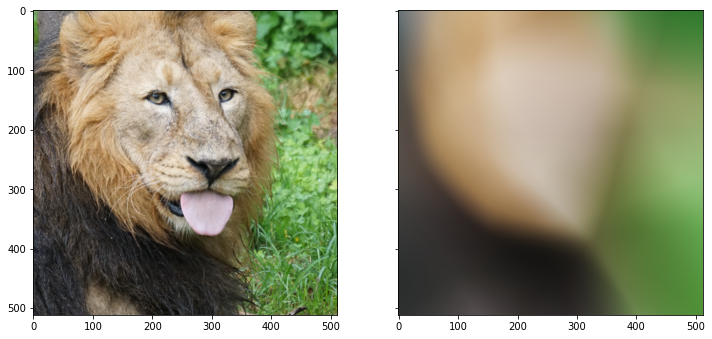

PSNR: tensor(18.2803)


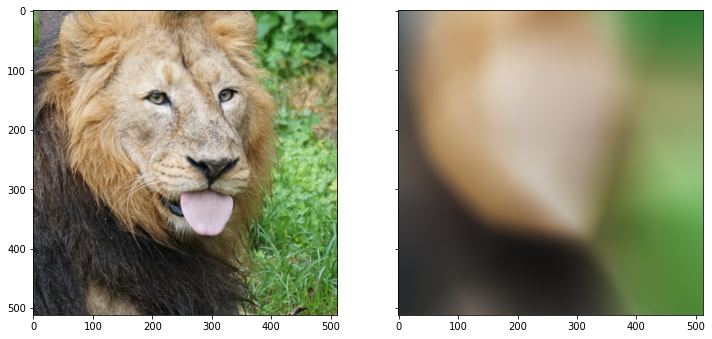

PSNR: tensor(18.5195)


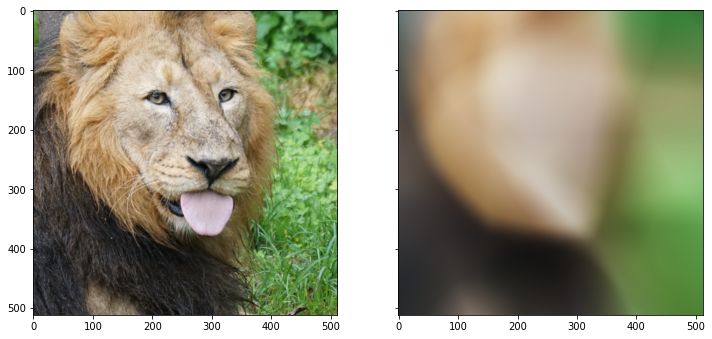

PSNR: tensor(18.6687)


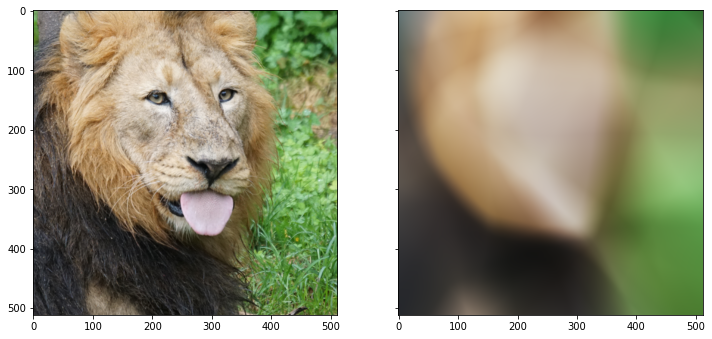

PSNR: tensor(18.8113)


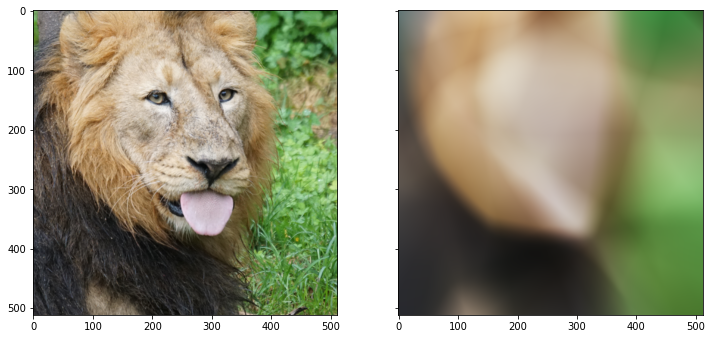

PSNR: tensor(18.9218)


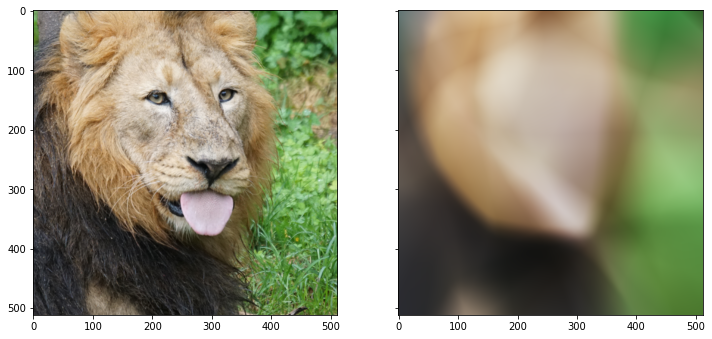

PSNR: tensor(19.0058)


In [216]:
train(model, criterion, optimizer, configs, x_train)